# Disaster Response Project

Here in this project we will analyze some Disaster Response Messages from the website https://appen.com/datasets/combined-disaster-response-data/ . It contains 30,000 messages and news articles from various disasters across the world(Eg: earthquake in Haiti in 2010, an earthquake in Chile in 2010, floods in Pakistan in 2010, super-storm Sandy in the U.S.A. in 2012 etc). that have happened.

We decided to build a Text Classification Pipeline by training on the data provided in the website so that we can successfully categorize an input message as disaster-related or un-related. After that the message will be classified into one of the groups given below for easier interpretation and response. Lastly, we will try to determine the internsity of the message.

Categories:  Message Related to: 

1. **Natural Disaster/Weather**- We included the columns 'cold', 'earthquake', 'storm', floods','other_weather'. This category will indicate all those messages which are related to these.

2.**Basic Necessities:** We included 'water','food','shelter','clothing','money' columns here. So it captures all the messages related to people requesting/talking about these basic necessities.

3. **Medical Urgency:** We included the columns 'medical_help', 'medical_products', 'hospitals' here. So these category will indicate all those messages where the sender may need immediate medical attention.

4. **Rescue/Man-power:** This includes columns 'death','military','security','child_alone','refugees','missing_people'. So this category will indicate all those messages where immediate man-power is needed eg: to rescue refugees, childern, collecting dead bodies, military relief or security forces.

To be honest, there will be messages which may be present in more than one category eg: food,water problem may present in **Natural Disaster/Weather** Category also. But overall the categorization will definitely help in categorizing disaster-messages into various ones so that it is easier to go through them and provide quick response.

We will also perform text analytics on the dataset so that we can draw important inferences/insights from them.

**Column Description**  (*note that not all the columns description are given in the website.....but they are pretty understandable*)

**id:** Unique ID for each individual row

**split:** Test, tune, validation split

**message:** English text of actual messages related to disaster

**original:** Text of column 3 in native language as originally written

**genre:** Type of message, including direct messages, social posting, and news stories or bulletins

**related:** Is the message disaster related? 1= yes, 0,2=no

**PII:** Does the message contain PII? 1= yes, 0=no

**request:** Does the message contain a request? 1= yes, 0=no

**offer:** Does the message contain an offer? 1= yes, 0=no

**aid_related:** Is the message aid related? 1= yes, 0=no

**medical_help:** Does the message concern medical help? 1= yes, 0=no

**medical_products:** Does the message concern medical products? 1= yes, 0=no

**search_and_rescue:** Does the message concern search and rescue? 1= yes, 0=no

**security:** Does the message concern security? 1= yes, 0=no

**military:** Does the message concern military? 1= yes, 0=no

**child_alone:** Does the message mention a child alone? 1= yes, 0=no

**water:** Does the message concern water? 1= yes, 0=no

**food:** Does the message concern food? 1= yes, 0=no

**shelter:** Does the message concern shelter? 1= yes, 0=no

**clothing:** Does the message concern clothing? 1= yes, 0=no

In [16]:
!pip install autocorrect

In [17]:
!pip install imblearn

In [18]:
!pip install catboost

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopword=stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer
lemm=WordNetLemmatizer()
from autocorrect import Speller
spell=Speller(lang='en')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
import imblearn
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import GradientBoostingClassifier

from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Classifying Messages as Disaster-Related or Not

In [22]:
# Read data
df=pd.read_csv('disaster_response_messages_training.csv')
display(df.head())
df_copy=df.copy()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,split,message,original,genre,related,PII,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [ ]:
# Most of the columns related to label 2 are in foreign language. So we discard them
df=df[df.related!=2]
df=df[['message','related']]

# Text preprocessing so that we can make it suitable for vectorization
df['message']=df['message'].str.lower()
list1=[]
wh_tok=WordPunctTokenizer()
for i in range(len(df)):
  tkk=wh_tok.tokenize(df.iloc[i,0])
  tkk=[i for i in tkk if i.isalpha() or i.isdigit()]
  list1.append((' '.join([lemm.lemmatize(spell(i)) for i in tkk if i not in stopword])))
df['clean_msg']=list1 # clean_msg column will contained the cleaned text after preprocessing

Note: **Vectorization** is converting text to numerical form/matrix of numbers as ML models cannot interpret text data. One option of vectorization is simple **CountVectorizer** which take bag-of-words approach into account for vectorization where words are assigned a a number according to their frequency in each document of the corpus. The problem/drawback with this model is that it ignores those words which are rare in document but are important.

**tf-idf model** solves that problem. So we use **tfidf vectorizer** here.

In [ ]:
# divide dataset into train and test set
X_train,X_test,y_train,y_test=train_test_split(df.clean_msg,df.related,stratify=df.related,test_size=0.24,random_state=222) 

# Vectorization of text using tf-idf vectorizer
tfidf=TfidfVectorizer()
tfidf_train=tfidf.fit_transform(X_train.values)
tfidf_test=tfidf.transform(X_test.values)

As we saw the dataset has highly imbalanced classes which migh bias the result of our prediction model in favor of the majority class. So we used an oversampling technique called **SMOTE(Synthetic Minority Oversampling Technique)** to deal with it. 

SMOTE works by creating synthetic data by looking at the neighbourhood of minority class.

In [ ]:
rs=SMOTE(random_state=55)
X_sampled,y_sample=rs.fit_sample(tfidf_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Using Logistic Regression algorithm to build classification model
lr=LogisticRegression(solver='lbfgs')
lr.fit(X_sampled,y_sample)
pred_trn=lr.predict(X_sampled)
pred_tst=lr.predict(tfidf_test)
print('Logistic Regression')
print('Training accuracy is: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst))
print('-------------------------------------------------------------------------')
print('\n') 

# Using Random Forest Clasifier algorithm to build classification model
rf1=RandomForestClassifier(random_state=3)
rf1.fit(X_sampled,y_sample)
pred_trn=rf1.predict(X_sampled)
pred_tst=rf1.predict(tfidf_test)
print('Random Forest Classifier')
print('Training accuracy is: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst)) 

Logistic Regression
Training accuracy is: 0.9115294901699433
              precision    recall  f1-score   support

           0       0.60      0.72      0.65      1220
           1       0.90      0.85      0.87      3791

    accuracy                           0.81      5011
   macro avg       0.75      0.78      0.76      5011
weighted avg       0.83      0.81      0.82      5011

-------------------------------------------------------------------------


Random Forest Classifier
Training accuracy is: 0.999083638787071
              precision    recall  f1-score   support

           0       0.62      0.59      0.61      1220
           1       0.87      0.88      0.88      3791

    accuracy                           0.81      5011
   macro avg       0.75      0.74      0.74      5011
weighted avg       0.81      0.81      0.81      5011



# 2. Classifying Disaster Messages into one of the 4 above mentioned Categories

To classify the messages into category...... we first take the columns mentioned before for each category. Each column will have either **0 or 1**. 1 means that the message is related to that column/feature. So we can sum up the features for each category and see which category has largest sum. The message will fall in the category with largest sum. Eg: the message is related to all the columns of **Natural Disaster** category(all 1s), but only one or two columns/features for others, so obviously the message is related to **Natural Disaster** category.

In [ ]:
# taking the columns for each category respectively
k1=['cold','earthquake','storm','floods','other_weather']
k2=['water','food','shelter','clothing','money']
k3=['medical_help','medical_products','hospitals']
k4=['military','death','military','security','child_alone','refugees','missing_people']

# so every category has different number of columns. If we just take the sum of each columns, then obviously the class will more columns will show greater which will definitely bias
# our result. So we normalized the sum by number of columns for each category.
df_copy['natural_dis']=df_copy[k1].sum(axis=1)/len(k1)
df_copy['basic_ness']=df_copy[k2].sum(axis=1)/len(k2)
df_copy['medical_ur']=df_copy[k3].sum(axis=1)/len(k3)
df_copy['request_manhelp']=df_copy[k4].sum(axis=1)/len(k4)

# If asum for all the categories is 0 then the message is unrelated to our interest so we discard it.
df1=df_copy[(df_copy.natural_dis>0)   |  (df_copy.basic_ness>0)  | (df_copy.medical_ur>0) | (df_copy.request_manhelp>0)]

# As mentioned the category with the highest sum will denote the category in which the message fall.
df1['Target']=df1[['natural_dis','basic_ness','medical_ur','request_manhelp']].idxmax(axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
# Preprocessing and cleaning the text message
df1['message']=df1['message'].str.lower()
list1=[]
wh_tok=WordPunctTokenizer()
for i in range(len(df1)):
  tkk=wh_tok.tokenize(df1.iloc[i,2])
  tkk=[i for i in tkk if i.isalpha() or i.isdigit()]
  list1.append((' '.join([lemm.lemmatize(spell(i)) for i in tkk if i not in stopword])))
df1['clean_msg']=list1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# divide dataset into train and test set
X_train,X_test,y_train,y_test=train_test_split(df1.clean_msg,df1.Target,stratify=df1.Target,test_size=0.24,random_state=222)

# Vectorization of text using tf-idf vectorizer
tfidf=TfidfVectorizer()
tfidf_train=tfidf.fit_transform(X_train.values)
tfidf_test=tfidf.transform(X_test.values)

In [ ]:
rs=SMOTE(random_state=55)
X_sampled,y_sample=rs.fit_sample(tfidf_train, y_train)

# Using Logistic Regression algorithm to build classification model
lr2=LogisticRegression(solver='lbfgs')
lr2.fit(X_sampled,y_sample)
pred_trn=lr2.predict(X_sampled)
pred_tst=lr2.predict(tfidf_test)
print('\n\n')
print('Logistic Regression')
print('Training accuracy is: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst))
print('-------------------------------------------------------------------------')
print('\n') 

# Using Gradient Boosing Tree Clasifier algorithm to build classification model
gb1=RandomForestClassifier(random_state=3)
gb1.fit(X_sampled,y_sample)
pred_trn=gb1.predict(X_sampled)
pred_tst=gb1.predict(tfidf_test)
print('Random Forest Classifier')
print('Training accuracy is: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst)) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression
Training accuracy is: 0.9345594525235243
                 precision    recall  f1-score   support

     basic_ness       0.82      0.75      0.78       667
     medical_ur       0.69      0.67      0.68       417
    natural_dis       0.84      0.87      0.86      1108
request_manhelp       0.63      0.72      0.67       241

       accuracy                           0.79      2433
      macro avg       0.75      0.75      0.75      2433
   weighted avg       0.79      0.79      0.79      2433

-------------------------------------------------------------------------


Random Forest Classifier
Training accuracy is: 0.9996435700028514
                 precision    recall  f1-score   support

     basic_ness       0.76      0.81      0.78       667
     medical_ur       0.77      0.59      0.67       417
    natural_dis       0.81      0.89      0.85      1108
request_manhelp       0.73      0.57      0.64       241

       accuracy                           0.79     

The **logistic regression model** has better performance as it **overfits** less(less difference between training and test cells).


We can try different other models and hyperparameter tuning for better performance.

# 3. Classifying whether a Message is Urgent for Each Categories

## Category 1 : Natural Disaster

We saw earler that there is huge class imbalance problem. To mitigate the situation, we have taken decided to take the monority class of all the 3 dataset whereas the majority class messages of the train dataset only. This is called data augmentation, where we include more data to improve our model.

In [20]:
df_v=pd.read_csv('disaster_response_messages_validation.csv')
df_v.head()

,id,split,message,original,genre,related,PII,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,8,validation,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,18,validation,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ...",direct,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,28,validation,are you going to call me or do you want me to ...,Eske se rele nap relem oubyen se mwen kap rele...,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,38,validation,"People I'm at Delma 2, we don't anything what ...",MEZANMI MWEN MWEN NAN DELMA 2 NOU TR MAN MAL N...,direct,1,0,1,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,48,validation,How we can find food and water? we have people...,Comment nou ka jwen dlo ak manje nou gen moun ...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
df_t=pd.read_csv('disaster_response_messages_validation.csv')
df_t.head()

,id,split,message,original,genre,related,PII,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,8,validation,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,18,validation,I am in Croix-des-Bouquets. We have health iss...,"Nou kwadebouke, nou gen pwoblem sant m yo nan ...",direct,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,28,validation,are you going to call me or do you want me to ...,Eske se rele nap relem oubyen se mwen kap rele...,direct,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,38,validation,"People I'm at Delma 2, we don't anything what ...",MEZANMI MWEN MWEN NAN DELMA 2 NOU TR MAN MAL N...,direct,1,0,1,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,48,validation,How we can find food and water? we have people...,Comment nou ka jwen dlo ak manje nou gen moun ...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Selecting the features for Natural Disaster category
dfc1=df_v[['cold','earthquake','storm','floods','other_weather','weather_related']]
dfc2=df_t[['cold','earthquake','storm','floods','other_weather','weather_related']]

dfc=df.copy()
dfc['N_C']=dfc[['cold','earthquake','storm','floods','other_weather','weather_related']].sum(axis=1)
dfc=pd.concat([dfc,dfc1,dfc2])

df_natur=dfc[dfc['N_C']>0]

In [ ]:
df_natur['N_C'].value_counts()

2.0    4508
3.0    1004
4.0     158
1.0     143
5.0      38
6.0      14
Name: N_C, dtype: int64

In [ ]:
# As we see in the above output that the sum of columns ranges from 1-6. Which means the messages are related to atmost 1 feature to all features for that category. We will take the messages related to more
# than two category as very urgent and others as urgent. It is because the messages related to more columns means people are distressed with more problems so needs quicker relief/attention
df_natur['Target']=np.where(df_natur['N_C']>2,1,0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# Cleaning text
list1=[]
wh_tok=WordPunctTokenizer()
for i in range(len(df_natur)):
  tkk=wh_tok.tokenize(df_natur.iloc[i,2])
  tkk=[i for i in tkk if i.isalpha() or i.isdigit()]
  list1.append((' '.join([lemm.lemmatize(spell(i)) for i in tkk if i not in stopword])))
df_natur['clean_msg']=list1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# Diving data into training and test set and also vectorizing text data
X_train,X_test,y_train,y_test=train_test_split(df_natur.clean_msg,df_natur.Target,stratify=df_natur.Target,test_size=0.24,random_state=222)


tfidf_train=tfidf.fit_transform(X_train.values)
tfidf_test=tfidf.transform(X_test.values)

In [ ]:
y_train.value_counts()

0    3534
1     923
Name: Target, dtype: int64

We see that there is great class imbalance present so we need to take that into account. First we will assign weights to each class based on the ratio of the frequency of each class in the training set. Obviously the minority clas will get more weight during training thus preventing bias towards majority class.

In [ ]:
# giving weight to target classes as mentioned above
from sklearn.utils.class_weight import compute_class_weight
weighting=compute_class_weight('balanced',[0,1],y_train)
print(weighting)
weights={0:weighting[0],1:weighting[1]}
print(weights)

[0.63058857 2.41440953]
{0: 0.6305885681946802, 1: 2.414409534127844}


In [ ]:
# building logistic regression and random forest classifier model with class weights

lr3=LogisticRegression(solver='lbfgs',class_weight=weights)
lr3.fit(tfidf_train,y_train)
pred_trn=lr3.predict(tfidf_train)
pred_tst=lr3.predict(tfidf_test)
print('Logistic Regression with Class Weights:')
print('The training accuracy: {}'.format(accuracy_score(y_train,pred_trn)))
print(classification_report(y_test,pred_tst))
print('-------------------------------------------------------------------')
print('\n') 

rb2=RandomForestClassifier(random_state=3,class_weight=weights)
rb2.fit(tfidf_train,y_train)
pred_trn=rb2.predict(tfidf_train)
pred_tst=rb2.predict(tfidf_test)
print('Random Forest Classifier with Class Weights:')
print('The training accuracy: {}'.format(accuracy_score(y_train,pred_trn)))
print(classification_report(y_test,pred_tst))

Logistic Regression with Class Weights:
The training accuracy: 0.8898362126991249
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1117
           1       0.46      0.63      0.53       291

    accuracy                           0.77      1408
   macro avg       0.68      0.72      0.69      1408
weighted avg       0.80      0.77      0.78      1408

-------------------------------------------------------------------


Random Forest Classifier with Class Weights:
The training accuracy: 0.9984294368409243
              precision    recall  f1-score   support

           0       0.82      0.98      0.89      1117
           1       0.67      0.15      0.25       291

    accuracy                           0.81      1408
   macro avg       0.74      0.57      0.57      1408
weighted avg       0.79      0.81      0.76      1408



In [ ]:
# We can also use SMOTE algorithm 
rs=SMOTE(random_state=55)
X_sampled,y_sample=rs.fit_sample(tfidf_train, y_train)

# building models after oversamplling with SMOTE
lr4=LogisticRegression(solver='lbfgs')
lr4.fit(X_sampled,y_sample)
print('\n\n')
print('Logistic Regression Algorithm:')
pred_trn=lr4.predict(X_sampled)
pred_tst=lr4.predict(tfidf_test)
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst))
print('---------------------------------------')
print('\n')

rb=RandomForestClassifier(random_state=3)
rb.fit(X_sampled,y_sample)
pred_trn=rb.predict(X_sampled)
pred_tst=rb.predict(tfidf_test)
print('Random Forest Classifier Algorithm:')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst))
print('---------------------------------------')
print('\n') 

xb=xgb.XGBClassifier(randon_state=41)
xb.fit(X_sampled,y_sample)
pred_trn=xb.predict(X_sampled)
pred_tst=xb.predict(tfidf_test)
print('Extra Gradient Boosting Algorithm:')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst))
print('---------------------------------------')
print('\n') 

import lightgbm as lgb
lgb=lgb.LGBMClassifier(random_state=11)
lgb.fit(X_sampled,y_sample)
pred_trn=lgb.predict(X_sampled)
pred_tst=lgb.predict(tfidf_test)
print('Light Gradient Boosting Algorithm:')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst)) 
print('---------------------------------------')
print('\n')

gb=GradientBoostingClassifier(random_state=1)
gb.fit(X_sampled,y_sample)
pred_trn=gb.predict(X_sampled)
pred_tst=gb.predict(tfidf_test)
print('Gradient Boosing Algorithm')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst)) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression Algorithm:
The training accuracy: 0.9105829088851161
              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1117
           1       0.49      0.57      0.53       291

    accuracy                           0.79      1408
   macro avg       0.69      0.71      0.69      1408
weighted avg       0.80      0.79      0.79      1408

---------------------------------------


Random Forest Classifier Algorithm:
The training accuracy: 0.9990096208262592
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1117
           1       0.71      0.32      0.44       291

    accuracy                           0.83      1408
   macro avg       0.78      0.64      0.67      1408
weighted avg       0.82      0.83      0.81      1408

---------------------------------------


Extra Gradient Boosting Algorithm:
The training accuracy: 0.8525749858517261
              precision    recall 

In [ ]:
cb=cb.CatBoostClassifier(random_state=412)
cb.fit(X_sampled,y_sample)
pred_trn=cb.predict(X_sampled)
pred_tst=cb.predict(tfidf_test)
print('Cat Boosting Classifier Algorithm:')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst)) 

Learning rate set to 0.023746
0:	learn: 0.6863508	total: 427ms	remaining: 7m 6s
1:	learn: 0.6803274	total: 762ms	remaining: 6m 20s
2:	learn: 0.6734438	total: 1.12s	remaining: 6m 11s
3:	learn: 0.6675311	total: 1.45s	remaining: 6m 1s
4:	learn: 0.6620508	total: 1.78s	remaining: 5m 54s
5:	learn: 0.6565847	total: 2.15s	remaining: 5m 56s
6:	learn: 0.6515607	total: 2.48s	remaining: 5m 52s
7:	learn: 0.6459335	total: 2.82s	remaining: 5m 50s
8:	learn: 0.6411894	total: 3.18s	remaining: 5m 49s
9:	learn: 0.6371240	total: 3.52s	remaining: 5m 48s
10:	learn: 0.6323382	total: 3.87s	remaining: 5m 47s
11:	learn: 0.6279871	total: 4.24s	remaining: 5m 49s
12:	learn: 0.6230726	total: 4.58s	remaining: 5m 48s
13:	learn: 0.6192959	total: 4.94s	remaining: 5m 48s
14:	learn: 0.6153374	total: 5.29s	remaining: 5m 47s
15:	learn: 0.6125006	total: 5.63s	remaining: 5m 46s
16:	learn: 0.6086507	total: 5.98s	remaining: 5m 45s
17:	learn: 0.6055267	total: 6.33s	remaining: 5m 45s
18:	learn: 0.6021759	total: 6.68s	remaining: 5

We saw that in terms of most least overfitted model, XGBoost did a great job. The training accuracy(0.85) and test accuracy(0.82) are really closer. 

If we give performance of the minority class more importance then Logistic Regression with class weight and catboost model performed performed well.

In this way we can try different models and oversampling/undersampling, hyperparameter tuning to improve our model according to our need.

(-0.5, 799.5, 799.5, -0.5)

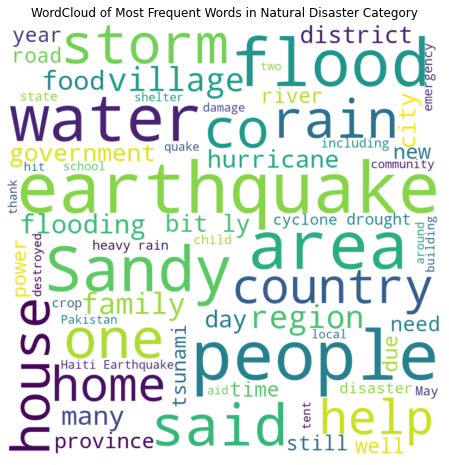

In [ ]:
# Creating wordcloud with most frequent word in the messages
list2=' '
for i in range(len(df_natur)):
   k=word_tokenize(df_natur.iloc[i,-1])
   for j in k:
     list2=list2+' '+j
wc=WordCloud(width=800,height=800,background_color='white',min_font_size=10,max_words=65).generate(list2)
plt.figure(figsize=(8,8))
plt.imshow(wc,interpolation='bilinear')
title=plt.title('WordCloud of Most Frequent Words in Natural Disaster Category')
plt.axis('off')

In wordcloud, a particular word used more number of time in text have relatively larger size. So we can see that words like Earthquake, Sandy, storm, flood,rain etc... are used a lot as expected.

## Category 2: Basic Necessities

In [ ]:
# taking relevant features from all the 3 datasets 
df_basic=df_copy[['message','water','food','shelter','clothing','money']]
df_basic1=df_v[['message','water','food','shelter','clothing','money']]
df_basic2=df_t[['message','water','food','shelter','clothing','money']]
df_basic=pd.concat([df_basic,df_basic1,df_basic2])
df_basic['total_necc']=df_basic.drop('message',axis=1).sum(axis=1)

In [ ]:
# creating target column just as done for Natural Disaster and and cleaning text
df_basic=df_basic[df_basic['total_necc']>0]
import numpy as np
df_basic['target']=np.where(df_basic['total_necc']>2,1,0)
df_basic['message']=df_basic['message'].str.lower()
list3=[]
wh_tok=WordPunctTokenizer()
for i in range(len(df_basic)):
  tkk=wh_tok.tokenize(df_basic.iloc[i,0])
  tkk=[i for i in tkk if i.isalpha() or i.isdigit()]
  list3.append((' '.join([lemm.lemmatize(spell(i)) for i in tkk if i not in stopword])))
df_basic['clean_msg']=list3

In [ ]:
# training and test set creating and vectorization of text data
X_train,X_test,y_train,y_test=train_test_split(df_basic.clean_msg,df_basic.target,stratify=df_basic.target,test_size=0.24,random_state=222)

tfidf_train=tfidf.fit_transform(X_train.values)
tfidf_test=tfidf.transform(X_test.values)

# SMOTE oversampling
rs=SMOTE(random_state=55)
X_sampled,y_sample=rs.fit_sample(tfidf_train, y_train)

# Fitting models
lr1=LogisticRegression(solver='lbfgs')
lr1.fit(X_sampled,y_sample)
pred_trn=lr1.predict(X_sampled)
pred_tst=lr1.predict(tfidf_test)
print('\n\n')
print('Logistic Regression Algorithm:')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst)) 
print('--------------------------------------------')
print('\n')

gb=GradientBoostingClassifier(random_state=1)
gb.fit(X_sampled,y_sample)
pred_trn=gb.predict(X_sampled)
pred_tst=gb.predict(tfidf_test)
print('GBM Algorithm:')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)





Logistic Regression Algorithm:
The training accuracy: 0.9664893617021276
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1188
           1       0.44      0.55      0.49       124

    accuracy                           0.89      1312
   macro avg       0.70      0.74      0.71      1312
weighted avg       0.90      0.89      0.90      1312

--------------------------------------------


GBM Algorithm:
The training accuracy: 0.9655585106382979
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1188
           1       0.65      0.55      0.59       124

    accuracy                           0.93      1312
   macro avg       0.80      0.76      0.78      1312
weighted avg       0.92      0.93      0.93      1312



**GBM(Gradient Boosting Model)** performed much better(less overfitting and better identified minority class).

(-0.5, 799.5, 799.5, -0.5)

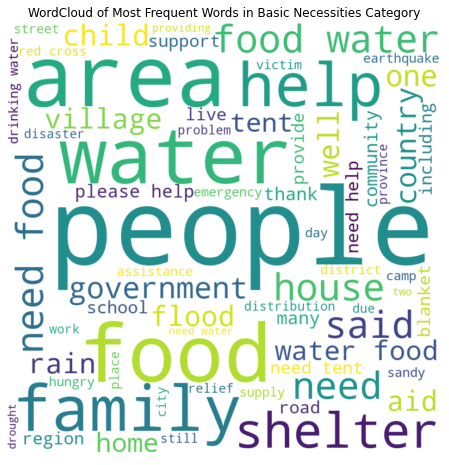

In [ ]:
# Creating wordcloud with most frequent word inj the messages
list2=' '
for i in range(len(df_basic)):
   k=word_tokenize(df_basic.iloc[i,-1])
   for j in k:
     list2=list2+' '+j

wc=WordCloud(width=800,height=800,background_color='white',min_font_size=10,max_words=65).generate(list2)
plt.figure(figsize=(8,8))
plt.imshow(wc,interpolation='bilinear')
title=plt.title('WordCloud of Most Frequent Words in Basic Necessities Category')
plt.axis('off')

In the category of **basic necessities**, we can see that words like water, help, area ,food, people, family, shelter are mostly use as expected.

## Category 3: Medical Urgency

In [ ]:
# Getting relevant rows for the category, creating target column and preprocessing text as done for the above categories
df_med=df[['message','medical_help','medical_products','hospitals']]
df_med1=df_v[['message','medical_help','medical_products','hospitals']]
df_med2=df_t[['message','medical_help','medical_products','hospitals']]
df_med=pd.concat([df_med,df_med1,df_med2])
df_med['total_med']=df_med.drop('message',axis=1).sum(axis=1)
df_med=df_med[df_med['total_med']>0]
df_med['target']=np.where(df_med['total_med']>2,1,0)

list5=[]
wh_tok=WordPunctTokenizer()
for i in range(len(df_med)):
  tkk=wh_tok.tokenize(df_med.iloc[i,0])
  tkk=[i for i in tkk if i.isalpha() or i.isdigit()]
  list5.append((' '.join([lemm.lemmatize(spell(i)) for i in tkk if i not in stopword])))
df_med['clean_msg']=list5

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(df_med.clean_msg,df_med.target,stratify=df_med.target,test_size=0.20,random_state=222)

tfidf_train=tfidf.fit_transform(X_train.values)
tfidf_test=tfidf.transform(X_test.values)

rs=SMOTE(random_state=55)
X_sampled,y_sample=rs.fit_sample(tfidf_train, y_train)

# Fitting models
lr2=LogisticRegression(solver='lbfgs')
lr2.fit(X_sampled,y_sample)
pred_trn=lr2.predict(X_sampled)
pred_tst=lr2.predict(tfidf_test)
print('\n\n')
print('Logistic Regression Algorithm:')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst)) 
print('--------------------------------------------')
print('\n')

from sklearn.ensemble import GradientBoostingClassifier
gb1=GradientBoostingClassifier(random_state=1)
gb1.fit(X_sampled,y_sample)
pred_trn=gb1.predict(X_sampled)
pred_tst=gb1.predict(tfidf_test)
print('GBM Algorithm:')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)





Logistic Regression Algorithm:
The training accuracy: 0.9980176211453744
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       568
           1       0.75      0.25      0.38        12

    accuracy                           0.98       580
   macro avg       0.87      0.62      0.68       580
weighted avg       0.98      0.98      0.98       580

--------------------------------------------


GBM Algorithm:
The training accuracy: 0.9927312775330397
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       568
           1       0.56      0.42      0.48        12

    accuracy                           0.98       580
   macro avg       0.77      0.70      0.73       580
weighted avg       0.98      0.98      0.98       580



**GBM** performed slightly better than logistic regression model.

(-0.5, 799.5, 799.5, -0.5)

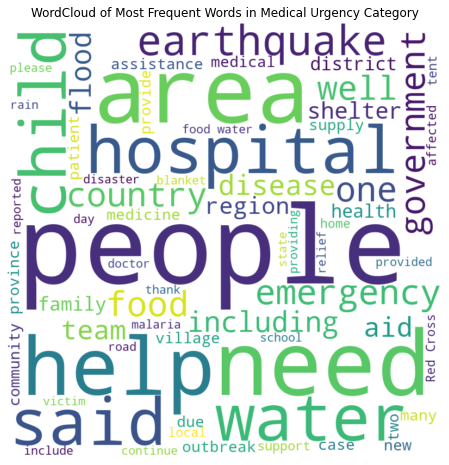

In [ ]:
# Creating WordCloud
list2=' '
for i in range(len(df_med)):
   k=word_tokenize(df_med.iloc[i,-1])
   for j in k:
     list2=list2+' '+j

from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc=WordCloud(width=800,height=800,background_color='white',min_font_size=10,max_words=65).generate(list2)
plt.figure(figsize=(8,8))
title=plt.title('WordCloud of Most Frequent Words in Medical Urgency Category')
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')

We see that in medical urgency field though there are words like emergency, medical, aid, hospital etc related to medical help but mostly words like people, water, area, child are more frequent.

## Category 4: Rescue/ Man-Power

In [23]:
# Getting relevant rows for the category, creating target column and preprocessing text as done for the above categories
df_rescue=df[['message','death','military','security','child_alone','refugees','missing_people']]
df_res1=df_v[['message','death','military','security','child_alone','refugees','missing_people']]
df_res2=df_t[['message','death','military','security','child_alone','refugees','missing_people']]
df_rescue=pd.concat([df_rescue,df_res1,df_res2])

df_rescue['total_res']=df_rescue.drop('message',axis=1).sum(axis=1)
df_rescue=df_rescue[df_rescue['total_res']>0]
df_rescue['target']=np.where(df_rescue['total_res']>2,1,0)

list4=[]
wh_tok=WordPunctTokenizer()
for i in range(len(df_rescue)):
  tkk=wh_tok.tokenize(df_rescue.iloc[i,0])
  tkk=[i for i in tkk if i.isalpha() or i.isdigit()]
  list4.append((' '.join([lemm.lemmatize(spell(i)) for i in tkk if i not in stopword])))
df_rescue['clean_msg']=list4

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(df_rescue.clean_msg,df_rescue.target,stratify=df_rescue.target,test_size=0.24,random_state=222)

tfidf_train=tfidf.fit_transform(X_train.values)
tfidf_test=tfidf.transform(X_test.values)
rs=SMOTE(random_state=55)
X_sampled,y_sample=rs.fit_sample(tfidf_train, y_train)

In [ ]:
lr2=LogisticRegression(solver='lbfgs')
lr2.fit(X_sampled,y_sample)
pred_trn=lr2.predict(X_sampled)
pred_tst=lr2.predict(tfidf_test)
print('\n\n')
print('Logistic Regression')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst)) 
print('--------------------------------------------')
print('\n')


gb1=GradientBoostingClassifier(random_state=1)
gb1.fit(X_sampled,y_sample)
pred_trn=gb1.predict(X_sampled)
pred_tst=gb1.predict(tfidf_test)
print('GBM Model')
print('The training accuracy: {}'.format(accuracy_score(y_sample,pred_trn)))
print(classification_report(y_test,pred_tst))




Logistic Regression
The training accuracy: 0.99860529986053
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       679
           1       0.47      0.21      0.29        33

    accuracy                           0.95       712
   macro avg       0.71      0.60      0.63       712
weighted avg       0.94      0.95      0.94       712

--------------------------------------------


GBM Model
The training accuracy: 0.9695490469549047
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       679
           1       0.26      0.18      0.21        33

    accuracy                           0.94       712
   macro avg       0.61      0.58      0.59       712
weighted avg       0.93      0.94      0.93       712



Both models performance is almost same but the precision, recall and f1-score for minority class is very low. Need more sohisticated sampling techniques here or complicated ML models.

(-0.5, 799.5, 799.5, -0.5)

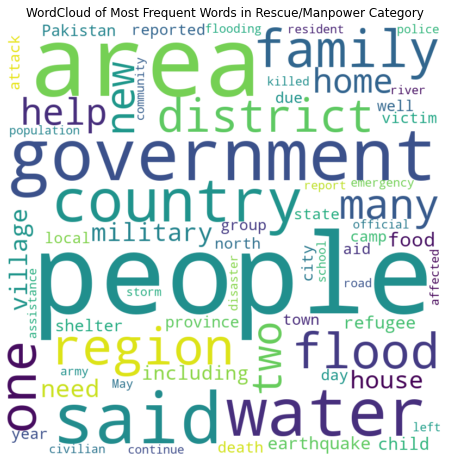

In [27]:
# Creating WordCloud
list2=' '
for i in range(len(df_rescue)):
   k=word_tokenize(df_rescue.iloc[i,-1])
   for j in k:
     list2=list2+' '+j


wc=WordCloud(width=800,height=800,background_color='white',min_font_size=10,max_words=65).generate(list2)
plt.figure(figsize=(8,8))
title=plt.title('WordCloud of Most Frequent Words in Rescue/Manpower Category')
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')

We see that words like **government, people, area, country** are most important.

# Important Keywords Frequency

We manually took some word after careful inspection and EDA of the text data and want to find out what is their overall frequency/counts of the sentences containing those words. This is very important because this will give an idea of how the people got affected by the disaster, what are their needs/what kind of help they need currently etc. Eg: high count of food will indicate that in a disaster shortage of food is a major issue..... 

Though WordCloud gives an idea of frequency of words, we created wordclouds for each category but we mentioned before there might be possibility of messages which may fall in more than one category so WordCloud might not perfectly represent their count. So we are taking all the messages into account this time.

In [8]:
# Loading the list of words manually created
key=pd.read_csv('manualkeywordsfinalized.txt',header=None)
key=key.T
key.head()

,0
0,necessities
1,Water
2,food
3,clothes
4,medicine


In [9]:
# preprocessing the words and creating two list
key[0]=key[0].str.lower()

# First list contains all the cleaned single words and 2nd list contains all the cleaned multi-words separated by underscore. They are separated because of ease of finding their counts/frequency
listA=[]
listB=[]
for i in range(len(key)):
  if len(key.iloc[i,0].split())<2:
    listA.append([lemm.lemmatize(spell(i)) for i in key.iloc[i,0].split() if i not in stopword][0])
  else:
    listB.append('_'.join([lemm.lemmatize(spell(i)) for i in key.iloc[i,0].split() if i not in stopword]))
print(listA)
print(listB)

listA=list(set(listA))
listB=list(set(listB))

['necessity', 'water', 'food', 'clothes', 'medicine', 'tent', 'diaper', 'price', 'communication', 'minute', 'digital', 'broadcast', 'hygiene', 'energy', 'fuel', 'diesel', 'gasoline', 'ambulance', 'infrastructure', 'service', 'school', 'passport', 'visa', 'bureau', 'carrefour', 'life', 'death', 'illness', 'sickness', 'injury', 'disaster', 'status', 'earthquake', 'stopped', 'aftershock', 'tremble', 'rain', 'weather', 'cyclone', 'shelter', 'mobility', 'passport', 'vehicle', 'car', 'bus', 'airport', 'currency', 'orphan', 'lonely', 'job', 'employment', 'appreciation', 'bless', 'love', 'god', 'prayer', 'agronomist', 'volunteer', 'god', 'shooting', 'stealing', 'joking']
['birth_control', 'radio_signal', 'gyber_café', 'national_ministry_education', 'social_affair', 'humanitarian_aid', 'child_baby', 'exchange_rate', 'american_dollar', 'mental_health', 'loss_family_member', 'house_destroyed', 'thank']


In [11]:
# cleaning the messages
df_key=df_copy[df_copy['related']==1]

df_key['message']=df_key['message'].str.lower()

list6=[]
#wh_tok=WordPunctTokenizer()
for i in range(len(df_key)):
  tkk=wh_tok.tokenize(df_key.iloc[i,2])
  tkk=[i for i in tkk if i.isalpha() ]
  list6.append((' '.join([lemm.lemmatize(spell(i)) for i in tkk if i not in stopword])))
df_key['clean_msg']=list6

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [13]:
df_key.head()

,id,split,message,original,genre,related,PII,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,water,food,shelter,clothing,money,missing_people,refugees,death,other_aid,infrastructure_related,transport,buildings,electricity,tools,hospitals,shops,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report,clean_msg
0,2,train,weather update - a cold front from cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,weather update cold front cuba could pas haiti
1,7,train,is the hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,hurricane
2,12,train,"says: west side of haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,say west side haiti rest country today tonight
4,15,train,storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,storm sacred heart jesus
5,16,train,"please, we need tents and water. we are in sil...",Tanpri nou bezwen tant avek dlo nou zon silo m...,direct,1,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,please need tent water silo thank


In [14]:
# finding the counts of the sentences containing each single word. list d1
d1=[]
df_key['clean_msg']=df_key['clean_msg'].astype('str')
for j in listA:
   for i in range(df_key.shape[0]):
        if j in df_key.iloc[i,-1].split():
           d1.append(j)

# finding the counts of the sentences containing each multi-word. list d2
df_key['clean_msg1']=df_key['clean_msg'].apply(lambda x: list(nltk.bigrams(x.split())))
d2=[]
for i in range(df_key.shape[0]):
  for j in df_key.iloc[i,-1]:
       if '_'.join(j) in listB:
         d2.append('_'.join(j))

d1=dict(Counter(d1))
d2=dict(Counter(d2))

freq=pd.concat([pd.DataFrame.from_dict(d1,orient='index').reset_index(), pd.DataFrame.from_dict(d2,orient='index').reset_index()])
freq.rename(columns={0:'count'},inplace=True)
freq.sort_values(by='count',inplace=True,ascending=False)
freq.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,count
18,food,1951
23,water,1829
36,earthquake,1460
28,rain,666
13,tent,650


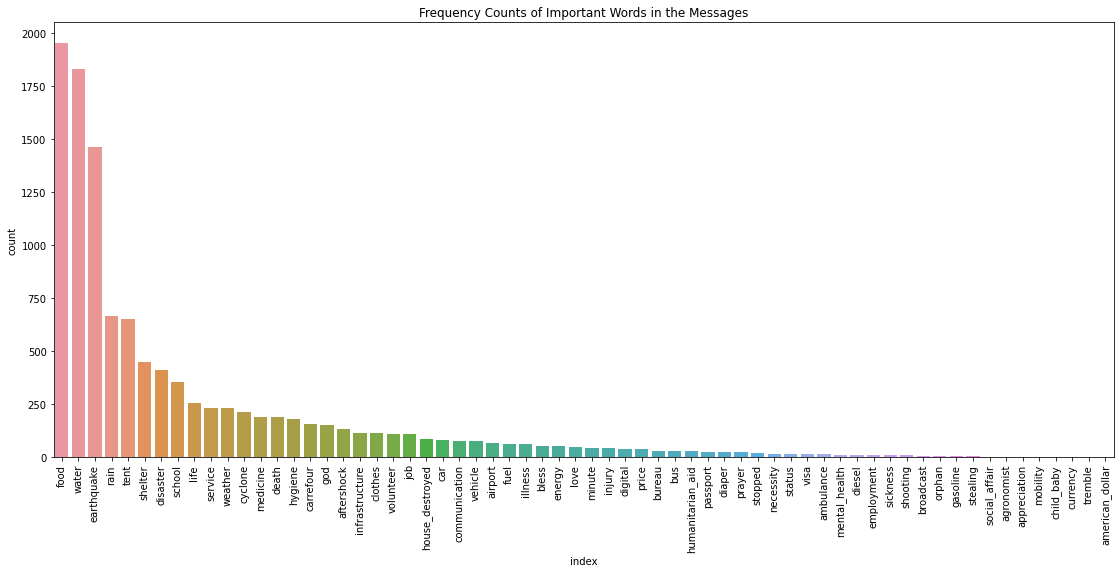

In [15]:
plt.figure(figsize=((19,8)))
bar=sns.barplot(data=freq,x='index',y='count')
xticks=plt.xticks(rotation=90)
title=plt.title('Frequency Counts of Important Words in the Messages')

We can clearly see which of the words are most mentioned in disaster messages. **Remember that if a sentence contains same word multiple times we will take into account it once. Our aim is to find the counts/frequency of sentences having that particular word.** 

We can see from plot, more people have pleaded for food,water,shelter, medicine etc.... i.e, basic necessities......  Also there are mentions of name of natural calamity they are facing eg: earthquake, rain etc as expected. 

There are also some words describing their situtation like house_destroyed........ There are words like job, volunteer etc which might indicate people are willing to volunteer to help disaster-affected people or they might even pleading for volunteers and job.

# Future Works:

This overall model if implemented can ne a great tool for effective disaster management. Some ways we can make the oveall idea better in future are:

1. By improving the accuracy of the model further and the precision, recall for the minority class more. We can use more sophisticated sampling techniques, stacking ML models together or state-of-art Deep Learning model, more EDA.

2. We must take into account those messages which might fall in more than one category. State-of-art Deep Learning language model can be deployed here for such complex tasks.

3. We can deploy the model in real time so that we can feed real-time/live disaster messages and get results immediately.